In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_cluster_0 = pd.read_csv("../portfolio_0_.csv")
df_cluster_1 = pd.read_csv("../portfolio_1_.csv")
df_cluster_2 = pd.read_csv("../portfolio_2_.csv")
df_cluster_3 = pd.read_csv("../portfolio_3_.csv")
df_cluster_4 = pd.read_csv("../portfolio_4_.csv")

In [14]:
df_adaboost2 = pd.read_csv("../portfolio_adaboost2_10.csv")

In [56]:
df_baseline = pd.read_csv("../portfolio_baseline.csv")

In [16]:
cluster_dfs = [df_cluster_0, df_cluster_1, df_cluster_2, df_cluster_3, df_cluster_4]

In [10]:
df_cluster_0.head()

,date,cash,equity,margin,market_value,pnl,unrealized_pnl,fees
0,2021-01-04,100000.0,100000.0,0.0,100000.0,0.0,0.0,0.0
1,2021-01-05,100000.0,100000.0,0.0,100000.0,0.0,0.0,0.0
2,2021-01-06,100000.0,100000.0,0.0,100000.0,0.0,0.0,0.0
3,2021-01-07,100000.0,100000.0,0.0,100000.0,0.0,0.0,0.0
4,2021-01-08,100000.0,100000.0,0.0,100000.0,0.0,0.0,0.0


In [68]:
combined_df = pd.DataFrame()

for df in cluster_dfs:
    df['date'] = pd.to_datetime(df['date'])
    if combined_df.empty:
        combined_df = df[['date', 'market_value']].copy()
        combined_df.rename(columns={'market_value': f'market_value_cluster_0'}, inplace=True)
    else:
        combined_df = combined_df.join(df[['market_value']], rsuffix=f'_cluster_{len(combined_df.columns)}')
        combined_df.rename(columns={'market_value': f'market_value_cluster_{len(combined_df.columns)-1}'}, inplace=True)

combined_df.set_index('date', inplace=True)

In [46]:
combined_df.tail()

,market_value_cluster_0,market_value_cluster_2,market_value_cluster_3,market_value_cluster_4,market_value_cluster_5,avg_market_value,avg_return,return,drawdown_pct
date,,,,,,,,,
2024-05-01,242441.67,105883.86,142772.37,68973.41,173925.21,146799.304,0.013760,0.463123,-0.184240
2024-05-02,243924.39,105702.90,151866.68,67167.59,173398.17,148411.946,0.010985,0.474108,-0.175278
2024-05-03,248805.01,107342.32,141238.39,67382.25,175857.69,148125.132,-0.001933,0.472176,-0.176872
2024-05-06,253562.08,107707.76,145621.19,67619.93,177263.13,150354.818,0.015053,0.487228,-0.164482
2024-05-07,252882.49,107615.96,143539.36,68092.39,177965.85,150019.210,-0.002232,0.484996,-0.166347


In [71]:
temp_df = df_cluster_0.copy()
temp_df['avg_return'] = temp_df['market_value'].pct_change().fillna(0)
temp_df['return'] = temp_df['avg_return'].cumsum()
std_error = temp_df['avg_return'].std() / (len(combined_df) ** 0.5)
std_error

0.0006334031412201394

In [3]:
def cal_portfolio_metrics(df):
    combined_df = df.copy()
    combined_df['avg_market_value'] = combined_df['market_value']
    combined_df['avg_return'] = combined_df['avg_market_value'].pct_change().fillna(0)
    combined_df['return'] = combined_df['avg_market_value'].pct_change().cumsum().fillna(0)
    combined_df['drawdown_pct'] = combined_df['avg_market_value'] / combined_df['avg_market_value'].cummax() - 1

    initial_market_value = combined_df.iloc[0]['avg_market_value']
    end_market_value = combined_df.iloc[-1]['avg_market_value']
    total_pnl = end_market_value - initial_market_value
    total_return = total_pnl/initial_market_value
    max_drawdown_pct = combined_df['drawdown_pct'].min()
    win_rate = (combined_df['avg_return'] > 0).mean()
    sharpe_ratio = combined_df['avg_return'].mean() / combined_df['avg_return'].std() * (252 ** 0.5)
    sortino_ratio = combined_df['avg_return'].mean() / combined_df[combined_df['avg_return'] < 0]['avg_return'].std() * (252 ** 0.5)
    equity_r2 = combined_df['avg_market_value'].corr(combined_df['avg_market_value'].shift(1)) ** 2
    std_error = combined_df['avg_return'].std() / (len(combined_df) ** 0.5)

    metrics = {
        'initial_market_value': initial_market_value,
        'end_market_value': end_market_value,
        'total_pnl': total_pnl,
        'total_return': total_return,
        'max_drawdown_pct': max_drawdown_pct,
        'win_rate': win_rate,
        'sharpe': sharpe_ratio,
        'sortino': sortino_ratio,
        'equity_r2': equity_r2,
        'std_error': std_error
    }

    print(metrics)

In [15]:
cal_portfolio_metrics(df_adaboost2)

{'initial_market_value': 100000.0, 'end_market_value': 145760.72, 'total_pnl': 45760.72, 'total_return': 0.4576072, 'max_drawdown_pct': -0.4690553937175038, 'win_rate': 0.49227110582639716, 'sharpe': 0.4783099004194001, 'sortino': 0.6029267193250053, 'equity_r2': 0.9721718100062848, 'std_error': 0.00096940184380091}


In [69]:
# average portfolio strategy

combined_df['avg_market_value'] = combined_df.mean(axis=1)
combined_df['avg_return'] = combined_df['avg_market_value'].pct_change().fillna(0)
combined_df['return'] = combined_df['avg_market_value'].pct_change().cumsum().fillna(0)
combined_df['drawdown_pct'] = combined_df['avg_market_value'] / combined_df['avg_market_value'].cummax() - 1

initial_market_value = combined_df.iloc[0]['avg_market_value']
end_market_value = combined_df.iloc[-1]['avg_market_value']
total_pnl = end_market_value - initial_market_value
total_return = total_pnl/initial_market_value
max_drawdown_pct = combined_df['drawdown_pct'].min()
win_rate = (combined_df['avg_return'] > 0).mean()
sharpe_ratio = combined_df['avg_return'].mean() / combined_df['avg_return'].std() * (252 ** 0.5)
sortino_ratio = combined_df['avg_return'].mean() / combined_df[combined_df['avg_return'] < 0]['avg_return'].std() * (252 ** 0.5)
equity_r2 = combined_df['avg_market_value'].corr(combined_df['avg_market_value'].shift(1)) ** 2
std_error = combined_df['avg_return'].std() / (len(combined_df) ** 0.5)

metrics = {
    'initial_market_value': initial_market_value,
    'end_market_value': end_market_value,
    'total_pnl': total_pnl,
    'total_return': total_return,
    'max_drawdown_pct': max_drawdown_pct,
    'win_rate': win_rate,
    'sharpe': sharpe_ratio,
    'sortino': sortino_ratio,
    'equity_r2': equity_r2,
    'std_error': std_error
}

print(metrics)

{'initial_market_value': 100000.0, 'end_market_value': 150019.21, 'total_pnl': 50019.20999999999, 'total_return': 0.5001920999999999, 'max_drawdown_pct': -0.21534405613238672, 'win_rate': 0.5148632580261593, 'sharpe': 0.6670246485249939, 'sortino': 0.9411818015275357, 'equity_r2': 0.9938686353230993, 'std_error': 0.0004732631215783756}


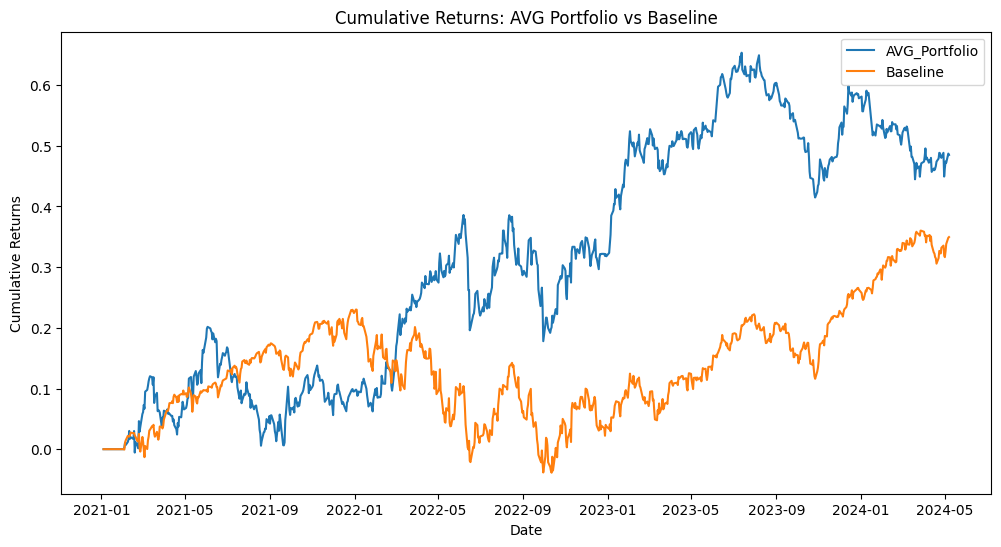

In [54]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x=combined_df.index, y='return', label='AVG_Portfolio')
sns.lineplot(data=df_baseline, x=df_baseline['date'], y='return', label='Baseline')
plt.title('Cumulative Returns: AVG Portfolio vs Baseline')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [75]:
compare_return_df = df_baseline[['date', 'return']].set_index('date').copy().join(combined_df[['date', 'cumsum_return']].copy().set_index('date'), rsuffix='_combined')
compare_return_df['difference'] = compare_return_df['cumsum_return'] - compare_return_df['return']

C:\Users\zhang\AppData\Local\Temp\ipykernel_2388\2022285450.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


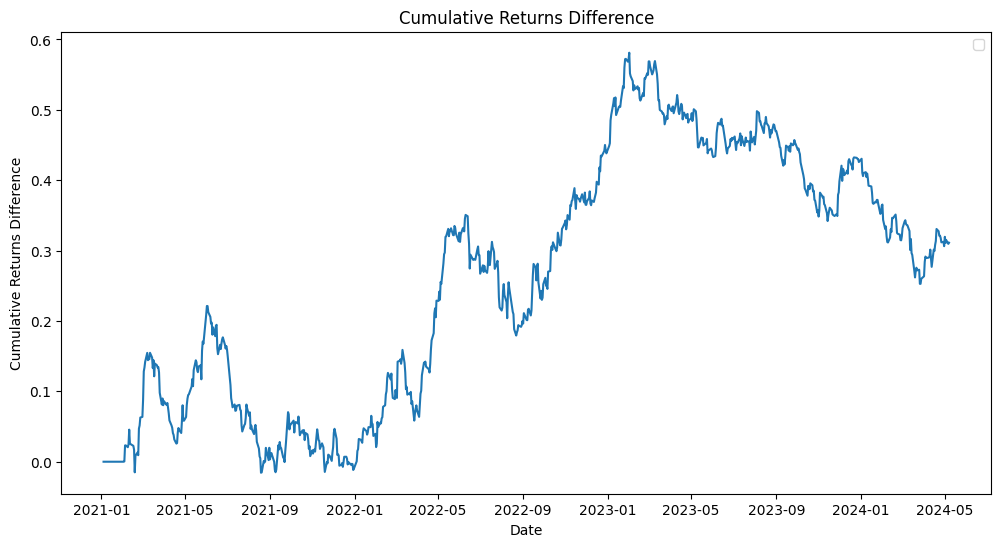

In [76]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=compare_return_df, x=compare_return_df.index, y='difference', label='')
plt.title('Cumulative Returns Difference')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns Difference')
plt.legend()
plt.show()

In [66]:
combined_df = pd.DataFrame()

for df in cluster_dfs:
    df['date'] = pd.to_datetime(df['date'])
    if combined_df.empty:
        combined_df = df[['date', 'market_value']].copy()
        combined_df.rename(columns={'market_value': f'market_value_cluster_0'}, inplace=True)
    else:
        combined_df = combined_df.join(df[['market_value']], rsuffix=f'_cluster_{len(combined_df.columns)}')
        combined_df.rename(columns={'market_value': f'market_value_cluster_{len(combined_df.columns)-1}'}, inplace=True)

combined_df.set_index('date', inplace=True)

In [67]:
combined_df.tail()

,market_value_cluster_0,market_value_cluster_2,market_value_cluster_3,market_value_cluster_4,market_value_cluster_5
date,,,,,
2024-05-01,242441.67,105883.86,142772.37,68973.41,173925.21
2024-05-02,243924.39,105702.90,151866.68,67167.59,173398.17
2024-05-03,248805.01,107342.32,141238.39,67382.25,175857.69
2024-05-06,253562.08,107707.76,145621.19,67619.93,177263.13
2024-05-07,252882.49,107615.96,143539.36,68092.39,177965.85


In [26]:
# momentum portfolio strategy

combined_df = pd.DataFrame()
for i, df in enumerate(cluster_dfs):
    df['date'] = pd.to_datetime(df['date'])
    combined_df[f'market_value_cluster_{i}'] = df['market_value']

In [27]:
returns_df = combined_df.pct_change().fillna(0)
returns_df.tail()

,market_value_cluster_0,market_value_cluster_1,market_value_cluster_2,market_value_cluster_3,market_value_cluster_4
836,0.013175,0.004321,0.042956,-0.024106,0.012681
837,0.006116,-0.001709,0.063698,-0.026181,-0.003030
838,0.020009,0.015510,-0.069984,0.003196,0.014184
839,0.019120,0.003404,0.031031,0.003527,0.007992
840,-0.002680,-0.000852,-0.014296,0.006987,0.003964


In [28]:
best_cluster = returns_df.idxmax(axis=1).shift(1).fillna("market_value_cluster_0")
combined_df['return'] = [
    returns_df.loc[idx, cluster] for idx, cluster in zip(returns_df.index, best_cluster)
]

In [44]:
combined_df.tail()

,market_value_cluster_0,market_value_cluster_1,market_value_cluster_2,market_value_cluster_3,market_value_cluster_4,return,cumsum_return,market_value,drawdown_pct
836,242441.67,105883.86,142772.37,68973.41,173925.21,0.001518,-0.140981,85901.853486,-0.324124
837,243924.39,105702.90,151866.68,67167.59,173398.17,0.016269,-0.077283,92271.650387,-0.274006
838,248805.01,107342.32,141238.39,67382.25,175857.69,-0.005070,-0.147268,85273.215971,-0.329070
839,253562.08,107707.76,145621.19,67619.93,177263.13,0.008511,-0.128148,87185.183097,-0.314026
840,252882.49,107615.96,143539.36,68092.39,177965.85,-0.001506,-0.142444,85755.562861,-0.325275


In [43]:
returns_df.tail()

,market_value_cluster_0,market_value_cluster_1,market_value_cluster_2,market_value_cluster_3,market_value_cluster_4
836,0.013175,0.004321,0.042956,-0.024106,0.012681
837,0.006116,-0.001709,0.063698,-0.026181,-0.003030
838,0.020009,0.015510,-0.069984,0.003196,0.014184
839,0.019120,0.003404,0.031031,0.003527,0.007992
840,-0.002680,-0.000852,-0.014296,0.006987,0.003964


In [45]:
(0.006116+0.001709+0.063698+0.003030)/4

0.018638250000000002

In [29]:
best_cluster

0      market_value_cluster_0
1      market_value_cluster_0
2      market_value_cluster_0
3      market_value_cluster_0
4      market_value_cluster_0
                ...          
836    market_value_cluster_3
837    market_value_cluster_2
838    market_value_cluster_2
839    market_value_cluster_0
840    market_value_cluster_2
Length: 841, dtype: object

In [32]:
# momentum strat
initial_market_value = combined_df.iloc[0]['market_value_cluster_0']
combined_df['cumsum_return'] = combined_df['return'].cumsum()
combined_df['market_value'] = (1+combined_df['cumsum_return'])*initial_market_value
combined_df['drawdown_pct'] = combined_df['market_value'] / combined_df['market_value'].cummax() - 1


end_market_value = combined_df.iloc[-1]['market_value']
total_pnl = end_market_value - initial_market_value
total_return = total_pnl/initial_market_value
max_drawdown_pct = combined_df['drawdown_pct'].min()
win_rate = (combined_df['return'] > 0).mean()
sharpe_ratio = combined_df['return'].mean() / combined_df['return'].std() * (252 ** 0.5)
sortino_ratio = combined_df['return'].mean() / combined_df[combined_df['return'] < 0]['return'].std() * (252 ** 0.5)
equity_r2 = combined_df['market_value'].corr(combined_df['market_value'].shift(1)) ** 2
std_error = combined_df['return'].std()

metrics = {
    'initial_market_value': initial_market_value,
    'end_market_value': end_market_value,
    'total_pnl': total_pnl,
    'total_return': total_return,
    'max_drawdown_pct': max_drawdown_pct,
    'win_rate': win_rate,
    'sharpe': sharpe_ratio,
    'sortino': sortino_ratio,
    'equity_r2': equity_r2,
    'std_error': std_error
}

print(metrics)

{'initial_market_value': 100000.0, 'end_market_value': 85755.56286136243, 'total_pnl': -14244.437138637571, 'total_return': -0.14244437138637572, 'max_drawdown_pct': -0.48302349274290013, 'win_rate': 0.469678953626635, 'sharpe': -0.11452315460561506, 'sortino': -0.14896066341393666, 'equity_r2': 0.9824642532209794, 'std_error': 0.02347773872383083}


In [50]:
combined_df = pd.DataFrame()
for i, df in enumerate(cluster_dfs):
    df['date'] = pd.to_datetime(df['date'])
    combined_df[f'market_value_cluster_{i}'] = df['market_value']

In [51]:
best_cluster = returns_df.idxmax(axis=1).shift(1).fillna("market_value_cluster_0")
worst_cluster = returns_df.idxmin(axis=1).shift(1).fillna("market_value_cluster_0")
# cols = list(returns_df.columns)
combined_df['return'] = [
    returns_df.drop(cluster, axis=1).loc[idx].mean() for idx, cluster in zip(returns_df.index, worst_cluster)
]

In [52]:
# momentum strat delete worse one

initial_market_value = combined_df.iloc[0]['market_value_cluster_0']
combined_df['cumsum_return'] = combined_df['return'].cumsum()
combined_df['market_value'] = (1+combined_df['cumsum_return'])*initial_market_value
combined_df['drawdown_pct'] = combined_df['market_value'] / combined_df['market_value'].cummax() - 1


end_market_value = combined_df.iloc[-1]['market_value']
total_pnl = end_market_value - initial_market_value
total_return = total_pnl/initial_market_value
max_drawdown_pct = combined_df['drawdown_pct'].min()
win_rate = (combined_df['return'] > 0).mean()
sharpe_ratio = combined_df['return'].mean() / combined_df['return'].std() * (252 ** 0.5)
sortino_ratio = combined_df['return'].mean() / combined_df[combined_df['return'] < 0]['return'].std() * (252 ** 0.5)
equity_r2 = combined_df['market_value'].corr(combined_df['market_value'].shift(1)) ** 2
std_error = combined_df['return'].std()

metrics = {
    'initial_market_value': initial_market_value,
    'end_market_value': end_market_value,
    'total_pnl': total_pnl,
    'total_return': total_return,
    'max_drawdown_pct': max_drawdown_pct,
    'win_rate': win_rate,
    'sharpe': sharpe_ratio,
    'sortino': sortino_ratio,
    'equity_r2': equity_r2,
    'std_error': std_error
}

print(metrics)

{'initial_market_value': 100000.0, 'end_market_value': 145625.81776221073, 'total_pnl': 45625.81776221073, 'total_return': 0.4562581776221073, 'max_drawdown_pct': -0.16404475096348925, 'win_rate': 0.5101070154577884, 'sharpe': 0.6234468246818629, 'sortino': 0.8926883829144129, 'equity_r2': 0.9943316788320405, 'std_error': 0.013813874902362204}


In [53]:
combined_df = pd.DataFrame()
for i, df in enumerate(cluster_dfs):
    df['date'] = pd.to_datetime(df['date'])
    combined_df[f'market_value_cluster_{i}'] = df['market_value']

In [54]:
best_cluster = returns_df.idxmax(axis=1).shift(1).fillna("market_value_cluster_0")
worst_cluster = returns_df.idxmin(axis=1).shift(1).fillna("market_value_cluster_0")
# cols = list(returns_df.columns)
combined_df['return'] = [
    returns_df.drop([w, b], axis=1).loc[idx].mean() for idx, w, b in zip(returns_df.index, worst_cluster, best_cluster)
]

In [55]:
# momentum strat delete best and worse one

initial_market_value = combined_df.iloc[0]['market_value_cluster_0']
combined_df['cumsum_return'] = combined_df['return'].cumsum()
combined_df['market_value'] = (1+combined_df['cumsum_return'])*initial_market_value
combined_df['drawdown_pct'] = combined_df['market_value'] / combined_df['market_value'].cummax() - 1

end_market_value = combined_df.iloc[-1]['market_value']
total_pnl = end_market_value - initial_market_value
total_return = total_pnl/initial_market_value
max_drawdown_pct = combined_df['drawdown_pct'].min()
win_rate = (combined_df['return'] > 0).mean()
sharpe_ratio = combined_df['return'].mean() / combined_df['return'].std() * (252 ** 0.5)
sortino_ratio = combined_df['return'].mean() / combined_df[combined_df['return'] < 0]['return'].std() * (252 ** 0.5)
equity_r2 = combined_df['market_value'].corr(combined_df['market_value'].shift(1)) ** 2
std_error = combined_df['return'].std()

metrics = {
    'initial_market_value': initial_market_value,
    'end_market_value': end_market_value,
    'total_pnl': total_pnl,
    'total_return': total_return,
    'max_drawdown_pct': max_drawdown_pct,
    'win_rate': win_rate,
    'sharpe': sharpe_ratio,
    'sortino': sortino_ratio,
    'equity_r2': equity_r2,
    'std_error': std_error
}

print(metrics)

{'initial_market_value': 100000.0, 'end_market_value': 166078.73356249355, 'total_pnl': 66078.73356249355, 'total_return': 0.6607873356249355, 'max_drawdown_pct': -0.1574611182772081, 'win_rate': 0.4994054696789536, 'sharpe': 0.8794077586138208, 'sortino': 1.3769227990129311, 'equity_r2': 0.9952026848373973, 'std_error': 0.014183247863269828}


In [60]:
df_baseline['return'] = df_baseline['market_value'].pct_change().cumsum().fillna(0)
df_baseline['date'] = pd.to_datetime(df_baseline['date'])

In [66]:
combined_df['date'] = pd.to_datetime(df_cluster_0['date'])

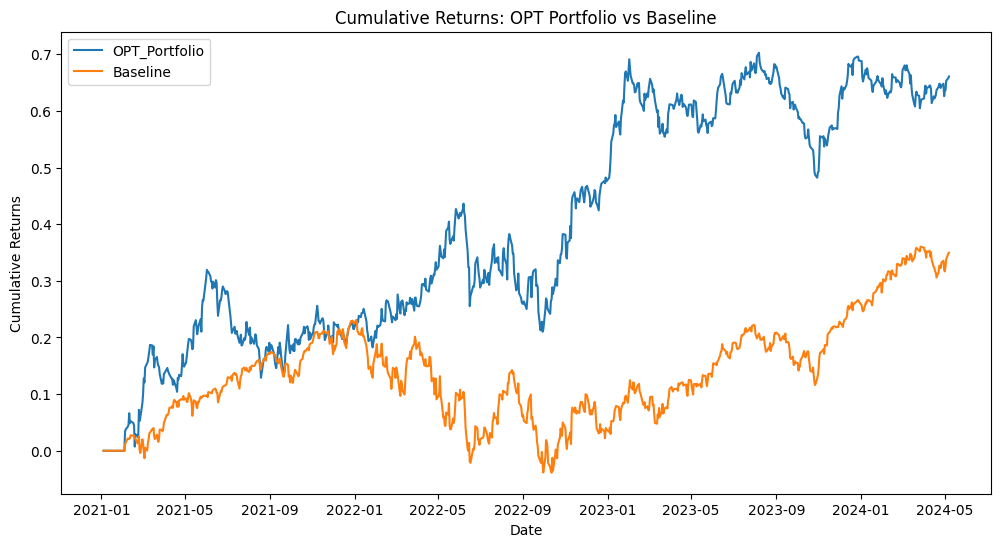

In [70]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x=combined_df['date'], y='cumsum_return', label='OPT_Portfolio')
sns.lineplot(data=df_baseline, x=df_baseline['date'], y='return', label='Baseline')
plt.title('Cumulative Returns: OPT Portfolio vs Baseline')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()